In [3]:
import time
import numpy as np
import torch
import torchquantum as tq
import torchquantum.functional as tqf
import torch.nn.functional as F
import torch.optim as optim
from torchquantum.plugins.qiskit_plugin import tq2qiskit
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from IPython.display import clear_output
from dataset import QuantumSensingDataset
from qnn import QuantumSensing, QuantumML0, QuantumML1, QuantumML2, QuantumML3, QuantumML4, NoQuantumML

In [33]:
# data
folder = '10x10.8'
# folder = 'toy'

root_dir = f'qml-data/{folder}/train'
train_dataset = QuantumSensingDataset(root_dir)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

root_dir = f'qml-data/{folder}/test'
test_dataset = QuantumSensingDataset(root_dir)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

print(train_dataset.__len__())
print(test_dataset.__len__())
print(train_dataset[1])

7500
2500
{'phase': array([1.7149485 , 2.0388026 , 1.2200979 , 1.779665  , 0.7763    ,
       1.320179  , 0.92079407, 0.70475376], dtype=float32), 'label': array(0)}


In [34]:
def compute_accuracy(output_all, target_all):
    _, indices = output_all.topk(1, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    return accuracy

# QuantumML0

In [35]:
# the model and training related variables
n_qubits = 8
n_locations = 10 * 10

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
model = QuantumML0(n_wires=n_qubits, n_locations=n_locations).to(device)
n_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for e in range(n_epochs):
    start = time.time()
    model.train()
    loss_list = []
    target_all = []
    output_all = []
    for t, sample in enumerate(train_dataloader):
        thetas = sample['phase']
        targets = sample['label'].to(device)
        # preparing sensing data
        bsz = thetas.shape[0]
        n_qubits = thetas.shape[1]
        qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
        qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
        qsensing(qstate)
        q_device = tq.QuantumDevice(n_wires=n_qubits)
        q_device.reset_states(bsz=bsz)
        # the model
        outputs = model(q_device, qstate.states)
        # compute loss, gradient, optimize, etc...
        loss = F.nll_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        target_all.append(targets)
        output_all.append(outputs)
        if t % 20 == 0:
            print(f'loss={loss.item()}')
    train_loss.append(np.mean(loss_list))
    target_all = torch.cat(target_all)
    output_all = torch.cat(output_all)
    accuracy = compute_accuracy(output_all, target_all)
    train_acc.append(accuracy)
    train_time = time.time() - start
    
    model.eval()
    loss_list = []
    target_all = []
    output_all = []
    with torch.no_grad():
        for t, sample in enumerate(test_dataloader):
            thetas = sample['phase']
            targets = sample['label'].to(device)
            bsz = thetas.shape[0]
            n_qubits = thetas.shape[1]
            qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
            qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
            qsensing(qstate)
            q_device = tq.QuantumDevice(n_wires=n_qubits)
            q_device.reset_states(bsz=bsz)
            # the model
            outputs = model(q_device, qstate.states)
            loss = F.nll_loss(outputs, targets)
            loss_list.append(loss.item())
            target_all.append(targets)
            output_all.append(outputs)
        target_all = torch.cat(target_all)
        output_all = torch.cat(output_all)
    test_loss.append(np.mean(loss_list))
    accuracy = compute_accuracy(output_all, target_all)
    test_acc.append(accuracy)
    scheduler.step()
    clear_output(True)
    epoch_time = time.time() - start
    print(f'training time elapse = {train_time:.2f}')
    print(f'epoch time elapse = {epoch_time:.2f}')
    print(f'epoch={e}')
    print(f'train loss={train_loss[-1]}')
    print(f'test loss={test_loss[-1]}')
    print(f'train accuracy={train_acc[-1]}')
    print(f'test accuracy={test_acc[-1]}')
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_loss, label='Train', linewidth=5)
    plt.plot(test_loss,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.subplot(1, 2, 2)
    plt.title('Localization Accuracy', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_acc, label='Train', linewidth=5)
    plt.plot(test_acc,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.show()

loss=4.642167568206787
loss=4.604316711425781
loss=4.580256462097168


KeyboardInterrupt: 

In [10]:
# testing a batch

i = 0

model.eval()
with torch.no_grad():
    for t, sample in enumerate(test_dataloader):
        thetas = sample['phase']
        targets = sample['label']
        for theta, target in zip(thetas, targets.cpu()):
            print(i, theta, target)
            i += 1
        targets = targets.to(device)
        continue
        bsz = thetas.shape[0]
        n_qubits = thetas.shape[1]
        qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
        qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
        qsensing(qstate)
        q_device = tq.QuantumDevice(n_wires=n_qubits)
        q_device.reset_states(bsz=bsz)
        # the model
        outputs = model(q_device, qstate.states)
        loss = F.nll_loss(outputs, targets)
        print('loss', loss.item())
        for theta, output, target in zip(thetas, outputs, targets):
            print(theta, output.cpu(), target.cpu())
#         print('outputs', outputs)
#         print('targets', targets)
        break

0 tensor([2.9227, 3.0481, 2.4822, 2.3924]) tensor(5)
1 tensor([3.9915, 2.2260, 2.7338, 1.9355]) tensor(2)
2 tensor([3.9607, 2.2567, 2.5768, 1.9726]) tensor(2)
3 tensor([2.5075, 3.9477, 1.9043, 2.1975]) tensor(4)
4 tensor([4.0930, 2.3567, 2.6433, 2.0027]) tensor(2)
5 tensor([2.0802, 2.5343, 2.2075, 3.9885]) tensor(13)
6 tensor([2.2052, 3.9096, 1.8837, 2.6858]) tensor(8)
7 tensor([2.6158, 3.9593, 2.0112, 2.1833]) tensor(4)
8 tensor([1.9621, 1.9861, 2.9948, 3.0784]) tensor(15)
9 tensor([2.1100, 2.5059, 2.3242, 3.9850]) tensor(13)
10 tensor([2.2279, 3.7637, 2.0995, 2.5903]) tensor(8)
11 tensor([2.3809, 2.0178, 3.9644, 2.6157]) tensor(11)
12 tensor([2.9538, 2.8408, 2.4419, 2.4564]) tensor(5)
13 tensor([2.3623, 3.9709, 1.9790, 2.6091]) tensor(8)
14 tensor([3.0624, 2.9770, 2.5480, 2.5391]) tensor(5)
15 tensor([3.9621, 2.2674, 2.5962, 2.1487]) tensor(2)
16 tensor([2.6062, 3.9565, 1.9567, 2.3214]) tensor(4)
17 tensor([1.9903, 3.1458, 1.9512, 2.9168]) tensor(12)
18 tensor([3.9626, 2.2842, 2.6679

# QuantumML1

epoch=24
train loss=0.38455748558044434
test loss=0.3957845526082175
train accuracy=1.0
test accuracy=1.0


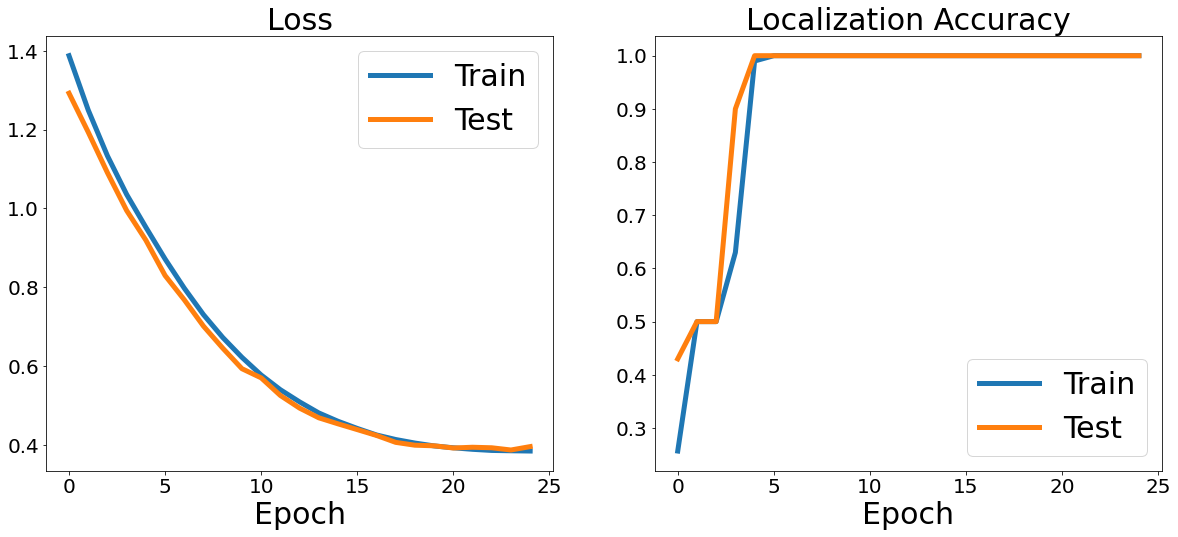

In [26]:
# the model and training related variables
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
model = QuantumML1(n_wires=4, n_locations=4).to(device)
n_epochs = 25
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for e in range(n_epochs):
    model.train()
    loss_list = []
    target_all = []
    output_all = []
    for t, sample in enumerate(train_dataloader):
        thetas = sample['phase']
        targets = sample['label'].to(device)
        # preparing sensing data
        bsz = thetas.shape[0]
        n_qubits = thetas.shape[1]
        qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
        qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
        qsensing(qstate)
        q_device = tq.QuantumDevice(n_wires=n_qubits)
        q_device.reset_states(bsz=bsz)
        # the model
        outputs = model(q_device, qstate.states)
        # compute loss, gradient, optimize, etc...
        loss = F.nll_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        target_all.append(targets)
        output_all.append(outputs)
        if t % 10 == 0:
            print(f'loss={loss.item()}')
    train_loss.append(np.mean(loss_list))
    target_all = torch.cat(target_all)
    output_all = torch.cat(output_all)
    accuracy = compute_accuracy(output_all, target_all)
    train_acc.append(accuracy)
    
    model.eval()
    loss_list = []
    target_all = []
    output_all = []
    with torch.no_grad():
        for t, sample in enumerate(test_dataloader):
            thetas = sample['phase']
            targets = sample['label'].to(device)
            bsz = thetas.shape[0]
            n_qubits = thetas.shape[1]
            qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
            qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
            qsensing(qstate)
            q_device = tq.QuantumDevice(n_wires=n_qubits)
            q_device.reset_states(bsz=bsz)
            # the model
            outputs = model(q_device, qstate.states)
            loss = F.nll_loss(outputs, targets)
            loss_list.append(loss.item())
            target_all.append(targets)
            output_all.append(outputs)
        target_all = torch.cat(target_all)
        output_all = torch.cat(output_all)
    test_loss.append(np.mean(loss_list))
    accuracy = compute_accuracy(output_all, target_all)
    test_acc.append(accuracy)
    scheduler.step()
    clear_output(True)
    print(f'epoch={e}')
    print(f'train loss={train_loss[-1]}')
    print(f'test loss={test_loss[-1]}')
    print(f'train accuracy={train_acc[-1]}')
    print(f'test accuracy={test_acc[-1]}')
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_loss, label='Train', linewidth=5)
    plt.plot(test_loss,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.subplot(1, 2, 2)
    plt.title('Localization Accuracy', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_acc, label='Train', linewidth=5)
    plt.plot(test_acc,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.show()

# QuantumML2

In [41]:
# the model and training related variables
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
model = QuantumML2(n_wires=4, n_locations=4).to(device)
n_epochs = 25
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

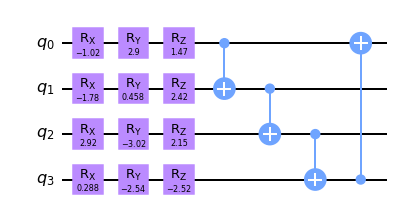

In [42]:
n_qubits = 4
dev = tq.QuantumDevice(n_wires=n_qubits)
qlayer = model.quantum_layer
circ = tq2qiskit(dev, qlayer)
circ.draw('mpl')

epoch=24
train loss=0.5715562889450475
test loss=0.5670066518442971
train accuracy=1.0
test accuracy=1.0


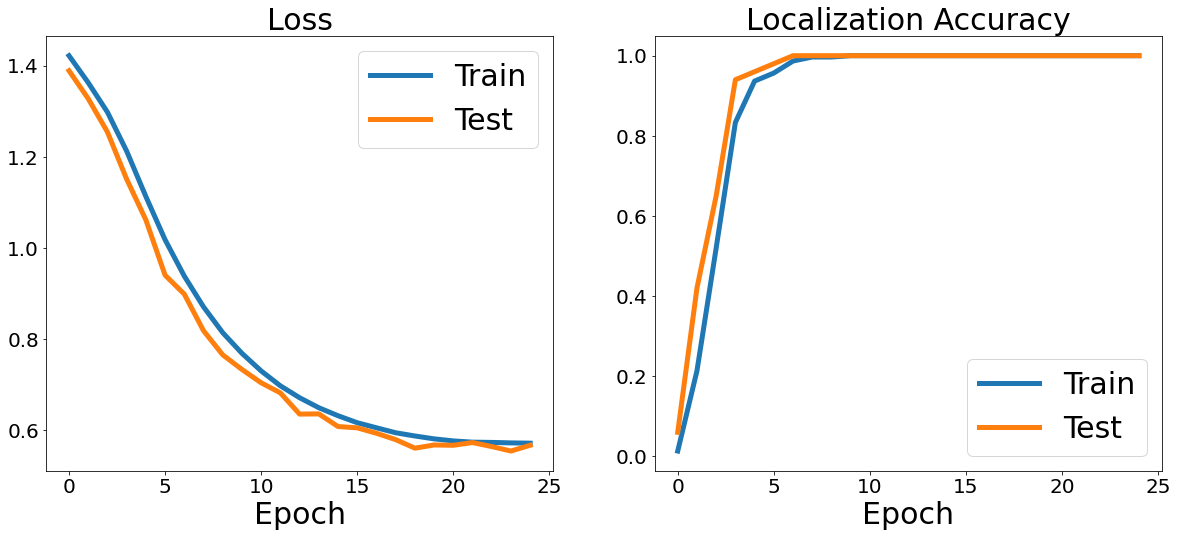

In [43]:
# the model and training related variables
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
model = QuantumML2(n_wires=4, n_locations=4).to(device)
n_epochs = 25
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for e in range(n_epochs):
    model.train()
    loss_list = []
    target_all = []
    output_all = []
    for t, sample in enumerate(train_dataloader):
        thetas = sample['phase']
        targets = sample['label'].to(device)
        # preparing sensing data
        bsz = thetas.shape[0]
        n_qubits = thetas.shape[1]
        qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
        qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
        qsensing(qstate)
        q_device = tq.QuantumDevice(n_wires=n_qubits)
        q_device.reset_states(bsz=bsz)
        # the model
        outputs = model(q_device, qstate.states)
        # compute loss, gradient, optimize, etc...
        loss = F.nll_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        target_all.append(targets)
        output_all.append(outputs)
        if t % 10 == 0:
            print(f'loss={loss.item()}')
    train_loss.append(np.mean(loss_list))
    target_all = torch.cat(target_all)
    output_all = torch.cat(output_all)
    accuracy = compute_accuracy(output_all, target_all)
    train_acc.append(accuracy)
    
    model.eval()
    loss_list = []
    target_all = []
    output_all = []
    with torch.no_grad():
        for t, sample in enumerate(test_dataloader):
            thetas = sample['phase']
            targets = sample['label'].to(device)
            bsz = thetas.shape[0]
            n_qubits = thetas.shape[1]
            qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
            qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
            qsensing(qstate)
            q_device = tq.QuantumDevice(n_wires=n_qubits)
            q_device.reset_states(bsz=bsz)
            # the model
            outputs = model(q_device, qstate.states)
            loss = F.nll_loss(outputs, targets)
            loss_list.append(loss.item())
            target_all.append(targets)
            output_all.append(outputs)
        target_all = torch.cat(target_all)
        output_all = torch.cat(output_all)
    test_loss.append(np.mean(loss_list))
    accuracy = compute_accuracy(output_all, target_all)
    test_acc.append(accuracy)
    scheduler.step()
    clear_output(True)
    print(f'epoch={e}')
    print(f'train loss={train_loss[-1]}')
    print(f'test loss={test_loss[-1]}')
    print(f'train accuracy={train_acc[-1]}')
    print(f'test accuracy={test_acc[-1]}')
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_loss, label='Train', linewidth=5)
    plt.plot(test_loss,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.subplot(1, 2, 2)
    plt.title('Localization Accuracy', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_acc, label='Train', linewidth=5)
    plt.plot(test_acc,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.show()

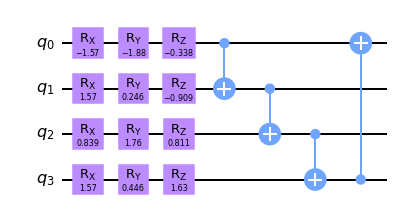

In [44]:
n_qubits = 4
dev = tq.QuantumDevice(n_wires=n_qubits)
qlayer = model.quantum_layer
circ = tq2qiskit(dev, qlayer)
circ.draw('mpl')

# QuantumML3

In [61]:
# the model and training related variables
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
model = QuantumML3(n_wires=4, n_locations=4).to(device)
n_epochs = 25
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

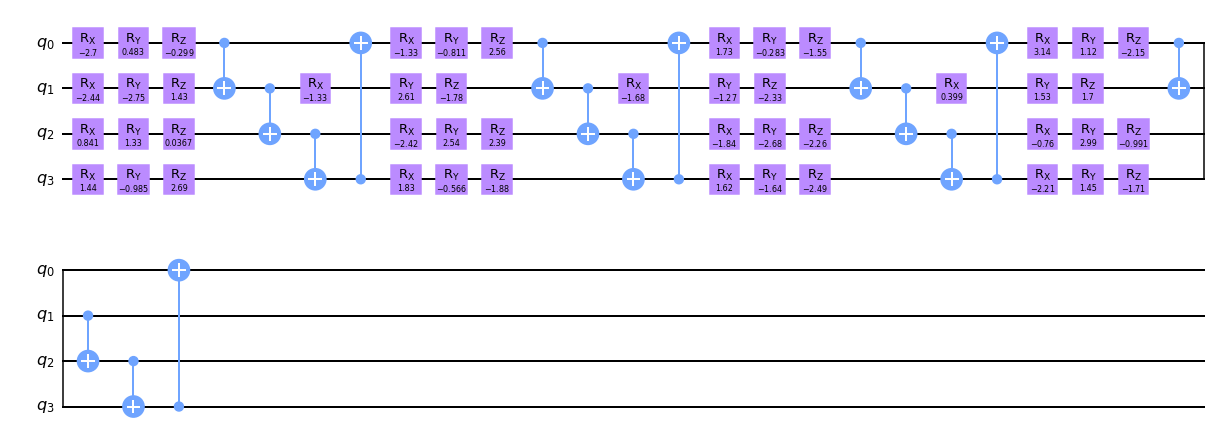

In [62]:
n_qubits = 4
dev = tq.QuantumDevice(n_wires=n_qubits)
qlayer = model.quantum_layer
circ = tq2qiskit(dev, qlayer)
circ.draw('mpl')

epoch=24
train loss=1.0931160575465153
test loss=1.0946258647101266
train accuracy=0.88
test accuracy=0.89


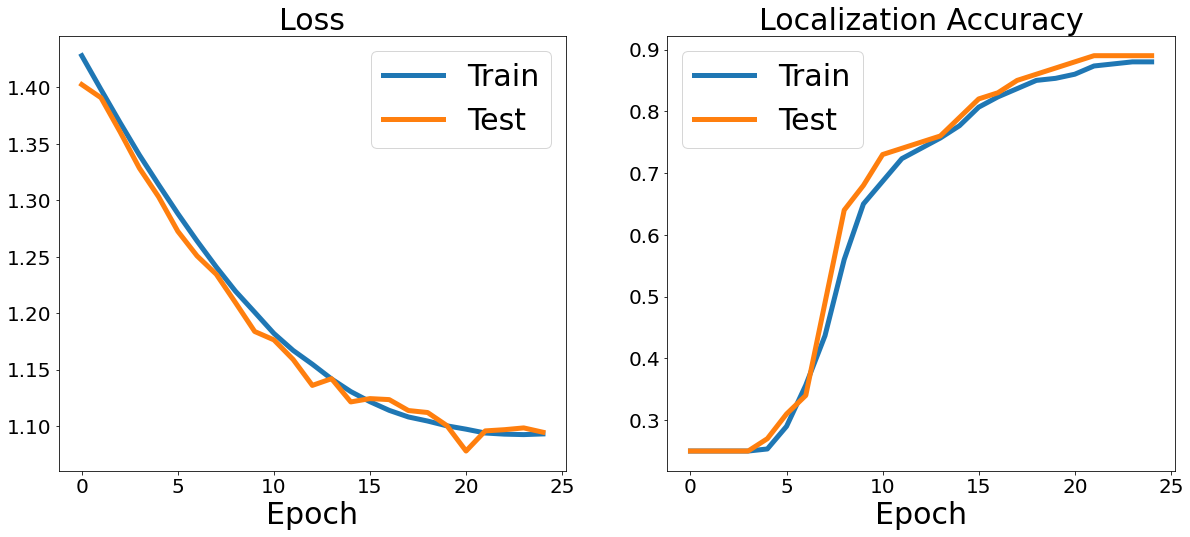

In [63]:
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for e in range(n_epochs):
    model.train()
    loss_list = []
    target_all = []
    output_all = []
    for t, sample in enumerate(train_dataloader):
        thetas = sample['phase']
        targets = sample['label'].to(device)
        # preparing sensing data
        bsz = thetas.shape[0]
        n_qubits = thetas.shape[1]
        qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
        qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
        qsensing(qstate)
        q_device = tq.QuantumDevice(n_wires=n_qubits)
        q_device.reset_states(bsz=bsz)
        # the model
        outputs = model(q_device, qstate.states)
        # compute loss, gradient, optimize, etc...
        loss = F.nll_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        target_all.append(targets)
        output_all.append(outputs)
        if t % 10 == 0:
            print(f'loss={loss.item()}')
    train_loss.append(np.mean(loss_list))
    target_all = torch.cat(target_all)
    output_all = torch.cat(output_all)
    accuracy = compute_accuracy(output_all, target_all)
    train_acc.append(accuracy)
    
    model.eval()
    loss_list = []
    target_all = []
    output_all = []
    with torch.no_grad():
        for t, sample in enumerate(test_dataloader):
            thetas = sample['phase']
            targets = sample['label'].to(device)
            bsz = thetas.shape[0]
            n_qubits = thetas.shape[1]
            qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
            qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
            qsensing(qstate)
            q_device = tq.QuantumDevice(n_wires=n_qubits)
            q_device.reset_states(bsz=bsz)
            # the model
            outputs = model(q_device, qstate.states)
            loss = F.nll_loss(outputs, targets)
            loss_list.append(loss.item())
            target_all.append(targets)
            output_all.append(outputs)
        target_all = torch.cat(target_all)
        output_all = torch.cat(output_all)
    test_loss.append(np.mean(loss_list))
    accuracy = compute_accuracy(output_all, target_all)
    test_acc.append(accuracy)
    scheduler.step()
    clear_output(True)
    print(f'epoch={e}')
    print(f'train loss={train_loss[-1]}')
    print(f'test loss={test_loss[-1]}')
    print(f'train accuracy={train_acc[-1]}')
    print(f'test accuracy={test_acc[-1]}')
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_loss, label='Train', linewidth=5)
    plt.plot(test_loss,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.subplot(1, 2, 2)
    plt.title('Localization Accuracy', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_acc, label='Train', linewidth=5)
    plt.plot(test_acc,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.show()

# QuantumML4

In [64]:
# the model and training related variables
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
model = QuantumML4(n_wires=4, n_locations=4).to(device)
n_epochs = 25
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

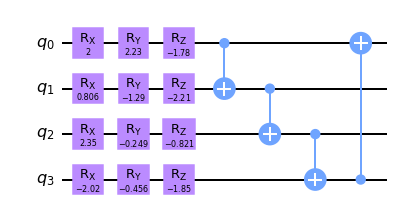

In [65]:
n_qubits = 4
dev = tq.QuantumDevice(n_wires=n_qubits)
qlayer = model.quantum_layer
circ = tq2qiskit(dev, qlayer)
circ.draw('mpl')

epoch=24
train loss=1.0028292254397744
test loss=0.9910663621766227
train accuracy=1.0
test accuracy=1.0


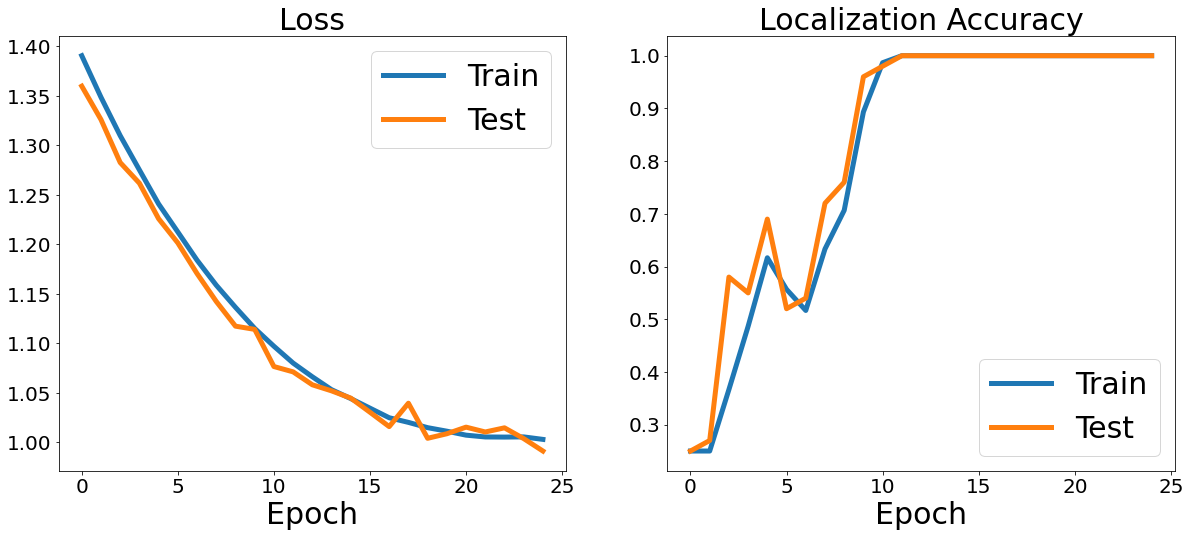

In [60]:
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for e in range(n_epochs):
    model.train()
    loss_list = []
    target_all = []
    output_all = []
    for t, sample in enumerate(train_dataloader):
        thetas = sample['phase']
        targets = sample['label'].to(device)
        # preparing sensing data
        bsz = thetas.shape[0]
        n_qubits = thetas.shape[1]
        qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
        qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
        qsensing(qstate)
        q_device = tq.QuantumDevice(n_wires=n_qubits)
        q_device.reset_states(bsz=bsz)
        # the model
        outputs = model(q_device, qstate.states)
        # compute loss, gradient, optimize, etc...
        loss = F.nll_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        target_all.append(targets)
        output_all.append(outputs)
        if t % 10 == 0:
            print(f'loss={loss.item()}')
    train_loss.append(np.mean(loss_list))
    target_all = torch.cat(target_all)
    output_all = torch.cat(output_all)
    accuracy = compute_accuracy(output_all, target_all)
    train_acc.append(accuracy)
    
    model.eval()
    loss_list = []
    target_all = []
    output_all = []
    with torch.no_grad():
        for t, sample in enumerate(test_dataloader):
            thetas = sample['phase']
            targets = sample['label'].to(device)
            bsz = thetas.shape[0]
            n_qubits = thetas.shape[1]
            qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
            qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
            qsensing(qstate)
            q_device = tq.QuantumDevice(n_wires=n_qubits)
            q_device.reset_states(bsz=bsz)
            # the model
            outputs = model(q_device, qstate.states)
            loss = F.nll_loss(outputs, targets)
            loss_list.append(loss.item())
            target_all.append(targets)
            output_all.append(outputs)
        target_all = torch.cat(target_all)
        output_all = torch.cat(output_all)
    test_loss.append(np.mean(loss_list))
    accuracy = compute_accuracy(output_all, target_all)
    test_acc.append(accuracy)
    scheduler.step()
    clear_output(True)
    print(f'epoch={e}')
    print(f'train loss={train_loss[-1]}')
    print(f'test loss={test_loss[-1]}')
    print(f'train accuracy={train_acc[-1]}')
    print(f'test accuracy={test_acc[-1]}')
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_loss, label='Train', linewidth=5)
    plt.plot(test_loss,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.subplot(1, 2, 2)
    plt.title('Localization Accuracy', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_acc, label='Train', linewidth=5)
    plt.plot(test_acc,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.show()

# NoQuantumML

In [4]:
# the model and training related variables
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
model = NoQuantumML(n_wires=4, n_locations=4).to(device)
n_epochs = 25
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

epoch=24
train loss=1.3863133882221423
test loss=1.3863591636930193
train accuracy=0.25
test accuracy=0.25


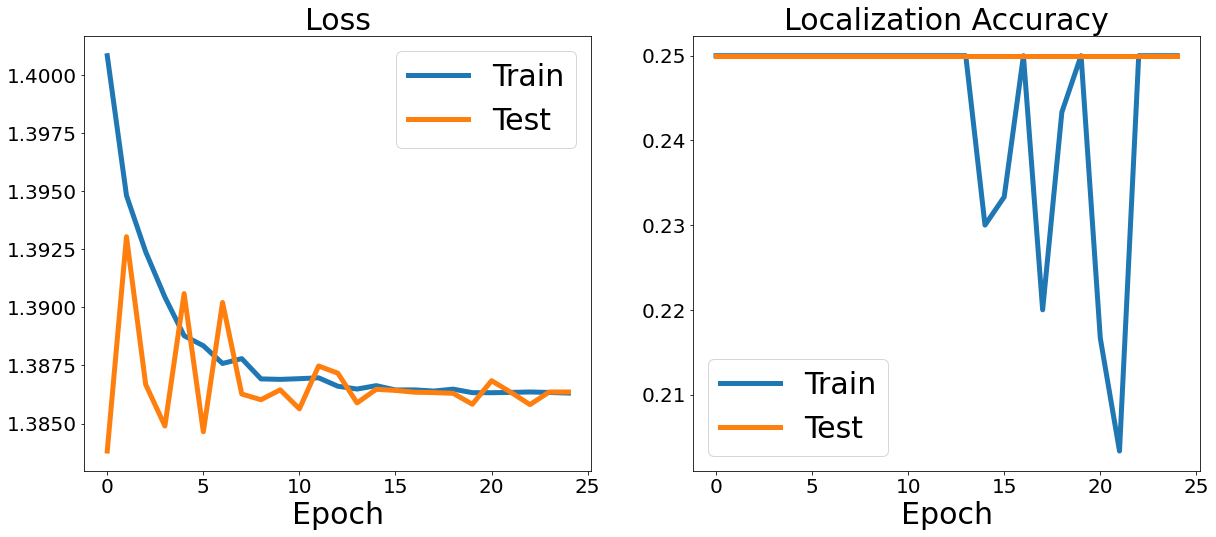

In [5]:
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for e in range(n_epochs):
    model.train()
    loss_list = []
    target_all = []
    output_all = []
    for t, sample in enumerate(train_dataloader):
        thetas = sample['phase']
        targets = sample['label'].to(device)
        # preparing sensing data
        bsz = thetas.shape[0]
        n_qubits = thetas.shape[1]
        qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
        qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
        qsensing(qstate)
        q_device = tq.QuantumDevice(n_wires=n_qubits)
        q_device.reset_states(bsz=bsz)
        # the model
        outputs = model(q_device, qstate.states)
        # compute loss, gradient, optimize, etc...
        loss = F.nll_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        target_all.append(targets)
        output_all.append(outputs)
        if t % 10 == 0:
            print(f'loss={loss.item()}')
    train_loss.append(np.mean(loss_list))
    target_all = torch.cat(target_all)
    output_all = torch.cat(output_all)
    accuracy = compute_accuracy(output_all, target_all)
    train_acc.append(accuracy)
    
    model.eval()
    loss_list = []
    target_all = []
    output_all = []
    with torch.no_grad():
        for t, sample in enumerate(test_dataloader):
            thetas = sample['phase']
            targets = sample['label'].to(device)
            bsz = thetas.shape[0]
            n_qubits = thetas.shape[1]
            qsensing = QuantumSensing(n_qubits=n_qubits, list_of_thetas=thetas, device=device)
            qstate = tq.QuantumState(n_wires=n_qubits, bsz=bsz)
            qsensing(qstate)
            q_device = tq.QuantumDevice(n_wires=n_qubits)
            q_device.reset_states(bsz=bsz)
            # the model
            outputs = model(q_device, qstate.states)
            loss = F.nll_loss(outputs, targets)
            loss_list.append(loss.item())
            target_all.append(targets)
            output_all.append(outputs)
        target_all = torch.cat(target_all)
        output_all = torch.cat(output_all)
    test_loss.append(np.mean(loss_list))
    accuracy = compute_accuracy(output_all, target_all)
    test_acc.append(accuracy)
    scheduler.step()
    clear_output(True)
    print(f'epoch={e}')
    print(f'train loss={train_loss[-1]}')
    print(f'test loss={test_loss[-1]}')
    print(f'train accuracy={train_acc[-1]}')
    print(f'test accuracy={test_acc[-1]}')
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_loss, label='Train', linewidth=5)
    plt.plot(test_loss,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.subplot(1, 2, 2)
    plt.title('Localization Accuracy', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_acc, label='Train', linewidth=5)
    plt.plot(test_acc,  label='Test', linewidth=5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=30)
    plt.show()